# Object Localization Notebook
#### Author: Tyler Newton  
  
### Implement a simple object detector for volcanics dataset.  
#### Goals:
- Use [AlpacaDB implementation of selective search](https://github.com/AlpacaDB/selectivesearch) to generate region proposals.
- Crop region proposals from input images and classify with pretrained model.  
- Perform [non-maximum supression](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c). 

In [30]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # Remove background from images # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# This doesn't work well on particles images. 

from rembg.bg import remove
# import rembg
import numpy as np
import io
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os

# specify image directories
ROOT = "/Users/human/Dropbox/Research/ML_image_classification/notebooks/particles"
images_dir = os.path.join(ROOT, 'originals')
output_dir = os.path.join(ROOT, 'background_removed')

# walk the image directories 
for _, _, files in os.walk(images_dir):
    # loop through files and skip . files
    for file in files:
        if file[0] != ".":
            print(file)
            # define filepaths for input and output
            input_path = os.path.join(images_dir, file)
            output_path = os.path.join(output_dir, file)

            # remove the background and save to new file
            f = np.fromfile(input_path)
            # parameters are manually tuned to work across classes
            result = remove(f, alpha_matting=True, alpha_matting_foreground_threshold=0.0001, alpha_matting_background_threshold=0.00000001, alpha_matting_base_size=100000000)
            img = Image.open(io.BytesIO(result)).convert("RGB")
            img.save(output_path)

a.png


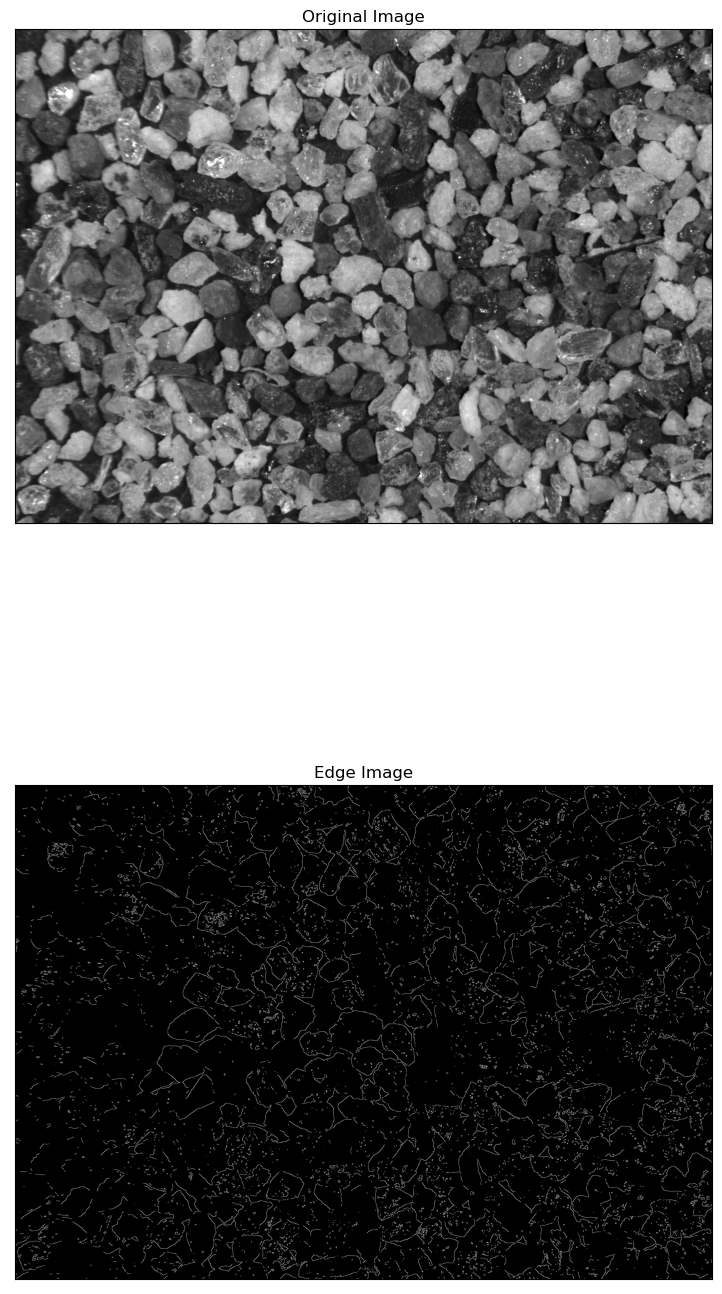

In [80]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # Canny edge detection # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html

import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

# read image
img = cv.imread('/Users/human/Dropbox/Research/ML_image_classification/notebooks/particles/originals/a.png',0)
# get edges from Canny edge detector
edges = cv.Canny(img, 130, 151, 3)

# plot the original and edges
plt.rcParams["figure.figsize"] = (9,18)
plt.subplot(211),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(212),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # Implement Selective Search # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

import selectivesearch
import matplotlib.patches as mpatches

# store results in dict
ss_dict = {}

# loop through all images in trainset
for index, image in enumerate(images):
    # get current image
    img = images[index].numpy()
    
    # apply selective search to image
    img_lbl, regions = selectivesearch.selective_search(img, scale=500, sigma=0.9, min_size=10)

    # narrow down selective search results
    candidates = set()
    for r in regions:
        # excluding same rectangle (with different segments)
        if r['rect'] in candidates:
            continue
        # excluding regions smaller than 2000 pixels
        if r['size'] < 500:
            continue
        # distorted rects
        x, y, w, h = r['rect']
        if w / h > 1.2 or h / w > 1.2:
            continue
        candidates.add(r['rect'])

    # # draw rectangles on the original image to plot region proposals
    # fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    # ax.imshow(img)
    # print("x, y, w, h")
    # for x, y, w, h in candidates:
    #     print(x, y, w, h)
    #     rect = mpatches.Rectangle(
    #         (x, y), w, h, fill=False, edgecolor='red', linewidth=1)
    #     ax.add_patch(rect)

    # plt.show()

    # store image, label, and region proposals in dict
    ss_dict[index] = [img, labels[index], candidates]

In [ ]:
# save/load selective search results
import pickle

# # save processed selective search region proposals as pickle file
# outfile = open('ss_dict.pkl', 'wb')
# pickle.dump(ss_dict, outfile)
# outfile.close()

# load region proposals from pickle file
infile = open('ss_dict.pkl', 'rb')
ss_dict = pickle.load(infile)
infile.close()

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # Load a model for classification # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# use deeplabv3_resnet101 from https://pytorch.org/vision/stable/models.html
import torchvision.models as models
# from torch.hub import load_state_dict_from_url
import torch

# assigns GPU as device if available
print(f'GPUs: {torch.cuda.device_count()}')
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(dev))

# import untrained model adapted for 10 classes and send it to the relevant device
model = models.segmentation.deeplabv3_resnet101(pretrained=True).to(dev)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'deeplabv3_resnet101', pretrained=True).to(dev)
# model.eval()

print(f"Model parameters: {len(list(model.parameters()))}")
print(f"Model architecture: \n{model}")

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # Crop region proposals # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# store cropped regions in a dict
crop_dict = {}

# loop through all entries (images) in selective search dict
for entry in ss_dict.keys():
    image = ss_dict[entry][0]
    label = ss_dict[entry][1]
    regions = ss_dict[entry][2]

    crop_dict[entry] = []
    for region in regions:
        # append image of cropped region from proposal
        x1 = region[0]
        x2 = region[0] + region[2]
        y1 = region[1]
        y2 = region[1] + region[3]
        crop_dict[entry].append(image[x1:x2, y1:y2, :])

In [ ]:
# classify cropped regions
from PIL import Image
from torch.utils.data import Dataset, DataLoader

label_dict = {}

# make a data class to transform cropped images
class DataTrans(Dataset):
    def __init__(self, data, labels, transform=None):
        self.transform = transform
        self.data = data
        self.labels = labels
            
    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        
        if self.transform:
            x = Image.fromarray(self.data[index])
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

# transform and load data into DataLoader
for entry in crop_dict.keys():
    print(f"{entry} of {len(crop_dict.keys())}")
    data = crop_dict[entry]
    labels = [int(ss_dict[entry][1]) for item in crop_dict[entry]]
    if len(labels) > 0:
        classset = DataTrans(data, labels, transform=transform)
        class_loader = DataLoader(classset, batch_size=len(classset), shuffle=False, num_workers=0)

        # get a batch of training data to preview
        dataiter = iter(class_loader)
        images, labels = dataiter.next() # gets all images in set

        # get classification predictions from pretrained model
        try:
            with torch.no_grad():
                output = model(images)['out']

            # store classification predictions for each cropped image
            label_dict[entry] = [[], []] # [[actual labels], [predicted labels]
            for index, label in enumerate(labels):
                prediction = int(torch.unique(output[index].argmax(0)).max())
                label_dict[entry][0].append(int(label))
                label_dict[entry][1].append(prediction)
        except:
            pass

In [ ]:
# save/load classification results

# save classifications as pickle file
outfile = open('label_dict.pkl', 'wb')
pickle.dump(label_dict, outfile)
outfile.close()

# # load classifications from pickle file
# infile = open('label_dict.pkl', 'rb')
# label_dict = pickle.load(infile)
# infile.close()

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # Non maximum supression # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# nms implementation from: https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/

# function to perform non max supression on a single image with multiple bounding boxes
def nms(bounding_boxes, threshold):
    
    if len(bounding_boxes) > 0:
        # list to store selected boxes
        selected_boxes = []
        # extract x's and y's
        x1 = bounding_boxes[:, 0]
        x2 = bounding_boxes[:, 1]
        y1 = bounding_boxes[:, 2]
        y2 = bounding_boxes[:, 3]
        
        # get area of bounding boxes
        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        indices = np.argsort(y2)
        
        while len(indices) > 0:
            last = len(indices) - 1
            i = indices[last]
            selected_boxes.append(i)
            suppress = [last]
            for pos in range(0, last):
                j = indices[pos]
                xx1 = max(x1[i], x1[j])
                yy1 = max(y1[i], y1[j])
                xx2 = min(x2[i], x2[j])
                yy2 = min(y2[i], y2[j])
                
                w = max(0, xx2 - xx1 + 1)
                h = max(0, yy2 - yy1 + 1)
                overlap = float(w*h) / area[j]
                
                if overlap > threshold:
                    suppress.append(pos)
                    
            indices = np.delete(indices, suppress)
            
        return bounding_boxes[selected_boxes]

nms_dict = {}
# loop through all entries in selective search dict
for entry in ss_dict.keys():
    image = ss_dict[entry][0]
    label = ss_dict[entry][1]
    regions = ss_dict[entry][2]
    region_list = []

    crop_dict[entry] = []
    for region in regions:
        # append image of cropped region from proposal
        x1 = region[0]
        x2 = region[0] + region[2]
        y1 = region[1]
        y2 = region[1] + region[3]
        region_list.append([x1, x2, y1, y2])
        
    region_array = np.array(region_list)
    nms_boxes = nms(region_array, 0.5)
    nms_dict[entry] = nms_boxes

In [ ]:
nms_dict